In [2]:
# Standard Libraries
import os

# Data Science

import numpy as np 
import pandas as pd

# Machine Learning

from sklearn.neighbors import KNeighborsClassifier

In [3]:
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

## The task

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).

## The Data

The data seems to be very simple. We have been given a *label* column which seems to be the target, and the rest of the 784 features are image pixes. These are 28 x 28 images, just like written in chapter and lab 3. So, we have a computer vision classification problem! Fascinating...

## Detailing the solution

We don't need to pre-process or scale anything here. Picking one random feature column i.e. *pixel100*, we see the min and max of: 0, 255. All sorts of values between these two extremes occur in this feature, which makes sense because an image pixel can fall between exactly those values.

OK. We already have a testing file, so all we need to do is to do cross-validation, RandomizedSearchCV, use KneighborsClassifier with the best hyperparameters, and cross our fingers that the accuracy is over 97%. Speaking of which, for the exercise it may be okay to use accuracy, but what performance measure would actually make sense here? 

It seems that, since KNN is a lazy learner, no binary cross-entropy or gradient descent is used, so simple accuracy or error rate works. But I will definitely use confusion matrices, precision, recall, F-1, ROC/PR curves, and everything learnt in the chapter to make this as robust as possible!

In [4]:
DIRECTORY_PREFIX = '/kaggle/input/digit-recognizer/'
submission, train, test = os.listdir(DIRECTORY_PREFIX)

In [5]:
train_df = pd.read_csv(DIRECTORY_PREFIX + train)
test_df = pd.read_csv(DIRECTORY_PREFIX + test)

train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Steps to implement RandomizedSearchCV

1. Define all the parameters for KNeighborsClassifier, what does what exactly
2. Once I understand this, I will know which types of values make sense for what, and the types of distributions to use
3. Define the parameter grid fully
4. Run RandomizedSearchCV
5. Evaluate the model and see if there are any improvements you can make
6. TESTING TIME

We need to check if the classes are balanced

In [9]:
print("Class balance: ", train_y.value_counts(), end='\n\n')
print("NaNs???: ", train_df.isna().sum(), end='\n\n')

Class balance:  label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

NaNs???:  label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64



## Cross Validation Antics

So, running RandomizedSearchCV gave us 96% validation set accuracy and awhopping 100%, badly overfitted training error: KNeighborsClassification is memorizing the entire training set with k=1 neighbors. We're in the process of testing higher ranges of k while excluding k=1 because we know that's optimal one.

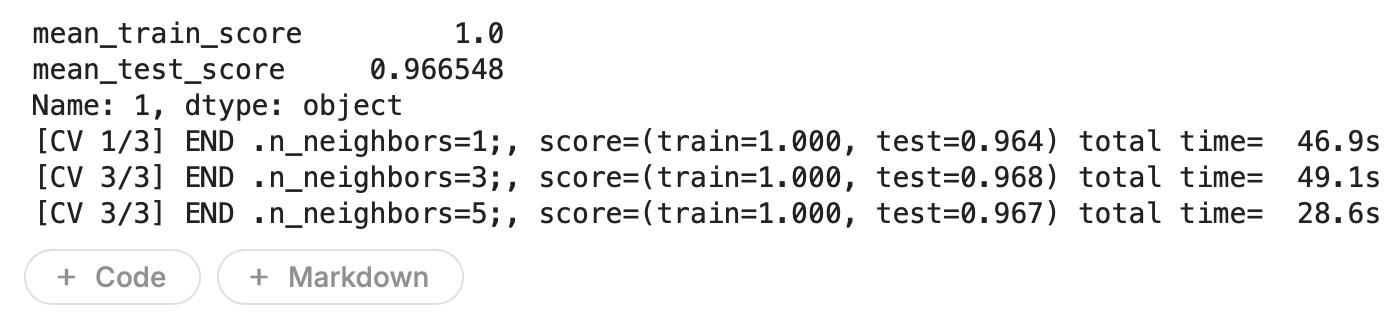

Why? Without actually testing both these models on real-world validation data outside of MNIST,we can't really conclude much about which model is superior. For the current purposes, I will go with one that reaches 95-96 training and above 90 validation. Then,the real work will begin: **collecting digit data out there and testing both models on it...**

In [7]:
train_y = train_df['label']
train_features = train_df.drop('label', axis=1)

param_grid = {
    'n_neighbors': [7, 9, 15, 21], 
}

rnd_search = RandomizedSearchCV(
    estimator=KNeighborsClassifier(n_jobs=-1, weights="distance"),
    param_distributions=param_grid,
    n_iter=10,           # Reduced from 30
    cv=3,                # Reduced from 5  
    scoring="accuracy",
    n_jobs=-1,
    verbose=3,            
    random_state=42,
    return_train_score=True
)

rnd_search.fit(train_features, train_y)
print("\nBest hyperparameters:")
print(rnd_search.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Best hyperparameters:
{'n_neighbors': 7}


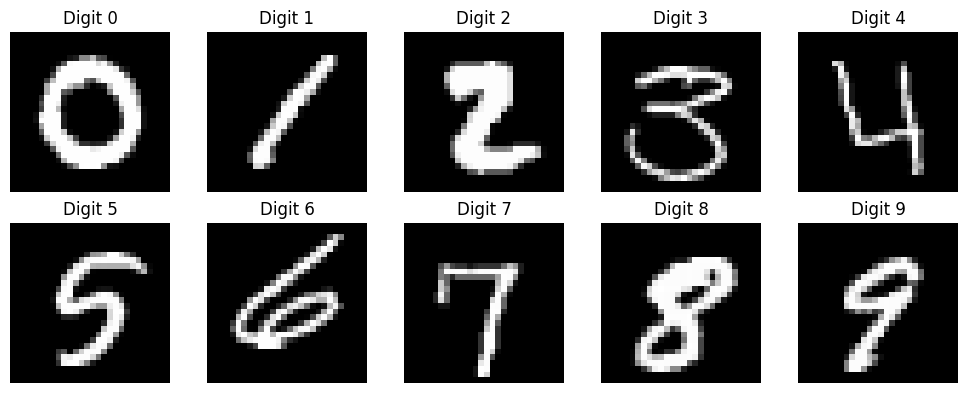

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i in range(10):
    sample = train_features[train_y==i].iloc[0].values.reshape(28, 28)
    axes[i//5, i%5].imshow(sample, cmap='gray')
    axes[i//5, i%5].set_title(f'Digit {i}')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

In [12]:
best_model = rnd_search.best_estimator_
best_idx = rnd_search.best_index_
results = pd.DataFrame(rnd_search.cv_results_)
best_row = results.iloc[best_idx][['mean_train_score', 'mean_test_score']]
best_row

mean_train_score         1.0
mean_test_score     0.964262
Name: 0, dtype: object

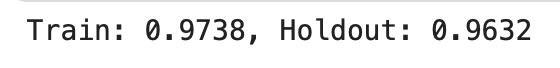



It seems the AI gods have spoken, we have decided upon the k=7 KNN model

In [15]:
from sklearn.model_selection import train_test_split

X_train_small, X_holdout, y_train_small, y_holdout = train_test_split(
    train_df, train_y, test_size=0.2, random_state=42
)

# Train on smaller set, test on holdout
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_small, y_train_small)

train_score = knn.score(X_train_small, y_train_small)  
holdout_score = knn.score(X_holdout, y_holdout)

print(f"Train: {train_score:.4f}, Holdout: {holdout_score:.4f}")

Train: 0.9738, Holdout: 0.9632
